# Exploritory Data Analysis

## Setup

In [1]:
import gc
import pathlib 

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import preprocessing

### Reading the combined dataset

We read the combined dataset, which is the product of `Combine Sources.ipynb` notebook.

In [2]:
combined_data_path = pathlib.Path.cwd().parent / 'datasets/raw' / 'combined.parquet'

In [3]:
data_df = pd.read_parquet(combined_data_path)

### Source 1 feature description

In [4]:
source_1_description_df: pd.DataFrame = pd.read_html('../datasets/raw/source_1/readme.html', skiprows=5)[0]

source_1_description_df.columns = ['Name', 'Description']
source_1_description_df = source_1_description_df.set_index('Name', drop=True)
source_1_description_df

,Description
Name,
Year,Year
Quarter,Quarter (1-4)
Month,Month
DayofMonth,Day of Month
DayOfWeek,Day of Week
...,...
Div5TotalGTime,Total Ground Time Away from Gate at Diverted A...
Div5LongestGTime,Longest Ground Time Away from Gate at Diverted...
Div5WheelsOff,Wheels Off Time (local time: hhmm) at Diverted...


### Source 2 feature description

In [5]:
source_2_description_df: pd.DataFrame = pd.read_csv("../datasets/raw/source_2/variable-descriptions.csv", skiprows=2, index_col=0, usecols=['Name', 'Description'])
source_2_description_df

,Description
Name,
Year,1987-2008
Month,12-Jan
DayofMonth,31-Jan
DayOfWeek,1 (Monday) - 7 (Sunday)
DepTime,"actual departure time (local, hhmm)"
CRSDepTime,"scheduled departure time (local, hhmm)"
ArrTime,"actual arrival time (local, hhmm)"
CRSArrTime,"scheduled arrival time (local, hhmm)"
UniqueCarrier,unique carrier code


### Handle missing values

Before we visualize the data, we determine percentage of missing values per feature.

In [6]:
perc_empty: pd.Series = preprocessing.percentage_missing_values_per_column(data_df)
print(perc_empty[perc_empty > 0])

AirTime              2.703047e+01
TaxiIn               2.573043e+01
TaxiOut              2.571812e+01
Tail_Number          2.539502e+01
ArrDelay             2.261258e+00
ActualElapsedTime    2.260889e+00
ArrTime              2.220742e+00
DepDelay             2.021100e+00
DepTime              2.020133e+00
Distance             1.363867e-01
OriginCityName       2.738200e-02
OriginState          2.738200e-02
DestState            2.618895e-02
DestCityName         2.618895e-02
CRSElapsedTime       1.743252e-02
DestAirport          6.751819e-07
dtype: float64


AirTime, TaxiIn, TaxiOut and Tail_Number features have a high rate of missing values. We delete these columns.

In [7]:
data_df.drop(['AirTime', 'TaxiIn', 'TaxiOut', 'Tail_Number'], axis=1, inplace=True)

The remaining columns contain very few samples with missing values, since we have more than a 100 million rows we just remove the rows with missing values.

In [8]:
perc_empty: pd.Series = preprocessing.percentage_missing_values_per_column(data_df)
print(perc_empty[perc_empty > 0])

ArrDelay             2.261258e+00
ActualElapsedTime    2.260889e+00
ArrTime              2.220742e+00
DepDelay             2.021100e+00
DepTime              2.020133e+00
Distance             1.363867e-01
OriginCityName       2.738200e-02
OriginState          2.738200e-02
DestState            2.618895e-02
DestCityName         2.618895e-02
CRSElapsedTime       1.743252e-02
DestAirport          6.751819e-07
dtype: float64


In [9]:
data_df.dropna(inplace=True)

### Limit the minimum of arrival and departure delays to be 0

In [10]:
data_df[['ArrDelay', 'DepDelay']].describe()

,ArrDelay,DepDelay
count,1.444829e+08,1.444829e+08
mean,6.373162e+00,8.301678e+00
std,3.497309e+01,3.265459e+01
min,-1.437000e+03,-1.410000e+03
25%,-9.000000e+00,-3.000000e+00
50%,-1.000000e+00,0.000000e+00
75%,1.000000e+01,6.000000e+00
max,7.232000e+03,7.223000e+03


The features containing delay information can also be negative. In this project we do not consider early departures, nor early arrivals. We thus limit the minimum of these features to 0, which indicates that a flight has departured or arrived on time.

In [11]:
data_df['ArrDelay'] = data_df['ArrDelay'].apply(lambda x: 0 if x < 0 else x)
data_df['DepDelay'] = data_df['DepDelay'].apply(lambda x: 0 if x < 0 else x)

### Convert types

The total memory usage of the dataset is very high, to reduce the memory usage and to improve performace we convert the column types to lower bit types.

In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144482939 entries, 0 to 148108239
Data columns (total 24 columns):
 #   Column             Dtype   
---  ------             -----   
 0   DayOfWeek          int64   
 1   DepDelay           float64 
 2   DepTime            float64 
 3   Origin             category
 4   DayofMonth         int64   
 5   CRSDepTime         int64   
 6   ArrTime            float64 
 7   Diverted           bool    
 8   Airline            category
 9   Distance           float64 
 10  Cancelled          bool    
 11  ActualElapsedTime  float64 
 12  OriginCityName     category
 13  OriginState        category
 14  CRSElapsedTime     float64 
 15  DestCityName       category
 16  Month              int64   
 17  ArrDelay           float64 
 18  DestAirport        category
 19  DestState          category
 20  Dest               category
 21  OriginAirport      category
 22  Year               int64   
 23  CRSArrTime         int64   
dtypes: bool(2), category

For each column that contains float values, we try to convert it to an integer column if and only if the conversion does not result in any data loss.

In [13]:
float_columns: pd.Index = data_df.select_dtypes(include=['float']).columns

for column in float_columns:
    if (data_df[column] == data_df[column].astype('int64')).all():
        data_df[column] = data_df[column].astype('int64')

### Convert int columns to fewer byte ints

In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144482939 entries, 0 to 148108239
Data columns (total 24 columns):
 #   Column             Dtype   
---  ------             -----   
 0   DayOfWeek          int64   
 1   DepDelay           int64   
 2   DepTime            int64   
 3   Origin             category
 4   DayofMonth         int64   
 5   CRSDepTime         int64   
 6   ArrTime            int64   
 7   Diverted           bool    
 8   Airline            category
 9   Distance           int64   
 10  Cancelled          bool    
 11  ActualElapsedTime  int64   
 12  OriginCityName     category
 13  OriginState        category
 14  CRSElapsedTime     int64   
 15  DestCityName       category
 16  Month              int64   
 17  ArrDelay           int64   
 18  DestAirport        category
 19  DestState          category
 20  Dest               category
 21  OriginAirport      category
 22  Year               int64   
 23  CRSArrTime         int64   
dtypes: bool(2), category

Now that all the float columns have been converted to 64 bit integers we attempt to further reduce the memory consumption by converting these integer columns to fewer bit integers.

In [15]:
integer_columns: pd.Index = data_df.select_dtypes(include=['int']).columns

for column in integer_columns:
    max_size = data_df[column].max()
    min_size = data_df[column].min()

    
    if min_size >= 0:
        if max_size <= np.iinfo(np.uint8).max:
            data_df[column] = data_df[column].astype('uint8')
        elif max_size <= np.iinfo(np.uint16).max:
            data_df[column] = data_df[column].astype('uint16')
        elif max_size <= np.iinfo(np.uint32).max:
            data_df[column] = data_df[column].astype('uint32')
        elif max_size <= np.iinfo(np.uint64).max:
            data_df[column] = data_df[column].astype('uint64')
    else:
        if max_size <= np.iinfo(np.int8).max and min_size >= np.iinfo(np.int8).min: 
            data_df[column] = data_df[column].astype('int8')
        elif max_size <= np.iinfo(np.int16).max and min_size >= np.iinfo(np.int16).min:
            data_df[column] = data_df[column].astype('int16')
        elif max_size <= np.iinfo(np.int32).max and min_size >= np.iinfo(np.int32).min:
            data_df[column] = data_df[column].astype('int32')
        elif max_size <= np.iinfo(np.int64).max and min_size >= np.iinfo(np.int64).min:
            data_df[column] = data_df[column].astype('int64')

In [16]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144482939 entries, 0 to 148108239
Data columns (total 24 columns):
 #   Column             Dtype   
---  ------             -----   
 0   DayOfWeek          uint8   
 1   DepDelay           uint16  
 2   DepTime            uint16  
 3   Origin             category
 4   DayofMonth         uint8   
 5   CRSDepTime         uint16  
 6   ArrTime            uint16  
 7   Diverted           bool    
 8   Airline            category
 9   Distance           uint16  
 10  Cancelled          bool    
 11  ActualElapsedTime  int16   
 12  OriginCityName     category
 13  OriginState        category
 14  CRSElapsedTime     int16   
 15  DestCityName       category
 16  Month              uint8   
 17  ArrDelay           uint16  
 18  DestAirport        category
 19  DestState          category
 20  Dest               category
 21  OriginAirport      category
 22  Year               uint16  
 23  CRSArrTime         uint16  
dtypes: bool(2), category

## Exploration

### Distribution of delays

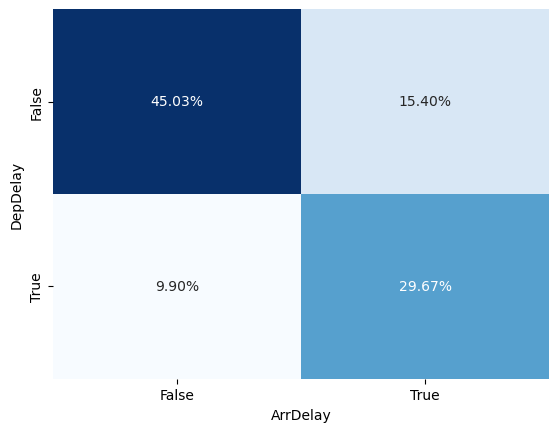

In [17]:
delays = data_df[['DepDelay', 'ArrDelay']].dropna()
delayed = (delays > 0).value_counts()

# The commented out code is for the bar chart, the heatmap is the one that is used
# delayed.plot(kind='barh', title='Departure and Arrival Delays', figsize=(10, 5))
# plt.savefig('figures/DepAndArrDelays.png')

sns.heatmap((delayed / sum(delayed)).unstack(), annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.savefig('figures/DepAndArrDelays.png')

The maximum arrival and departure delays are around 5 days. If we were to use these delays in some of our plots, the plots would be difficult to read because these extreme values would need very wide axes.
For this reason, we limit the delays to only include 97.5 percent of data.

In [18]:
quantile: float = 0.975
delay_975_percentile = data_df[['ArrDelay', 'DepDelay']].quantile(quantile)
delay_975_percentile

ArrDelay    92.0
DepDelay    87.0
Name: 0.975, dtype: float64

/var/folders/c9/24l9wbvn7_l_zt25742x5qf40000gn/T/ipykernel_17410/3696008690.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  sns.displot(delays[delays <= delay_975_percentile]['ArrDelay'], bins=50, kde=False).set(title='Arrival Delay Distribution')


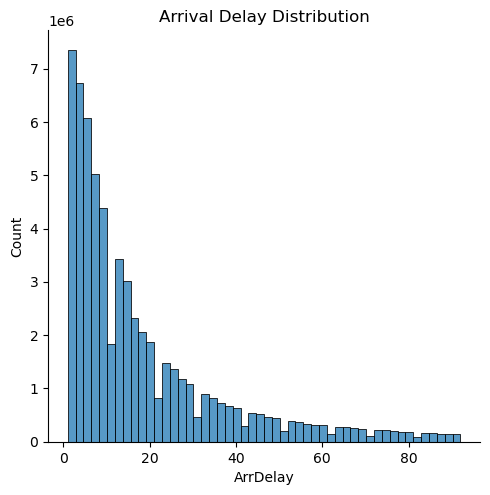

In [19]:
delays = delays[delays > 0]
sns.displot(delays[delays <= delay_975_percentile]['ArrDelay'], bins=50, kde=False).set(title='Arrival Delay Distribution')
plt.savefig('figures/ArrDelayDistribution.png')

/var/folders/c9/24l9wbvn7_l_zt25742x5qf40000gn/T/ipykernel_17410/290637672.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  sns.displot(delays[delays <= delay_975_percentile]['DepDelay'], bins=50, kde=False).set(title='Departure Delay Distribution')


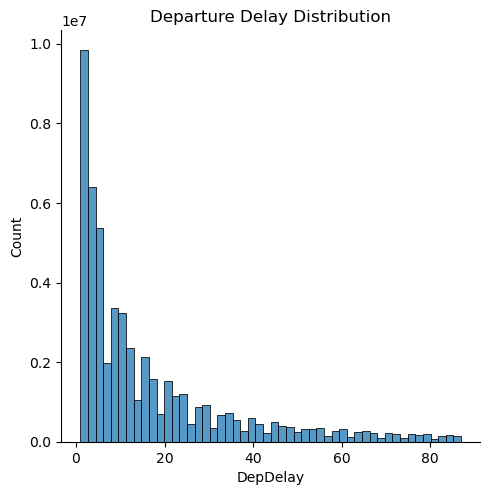

In [20]:
sns.displot(delays[delays <= delay_975_percentile]['DepDelay'], bins=50, kde=False).set(title='Departure Delay Distribution')
plt.savefig('figures/DepDelayDistribution.png')

### Distribution of flights

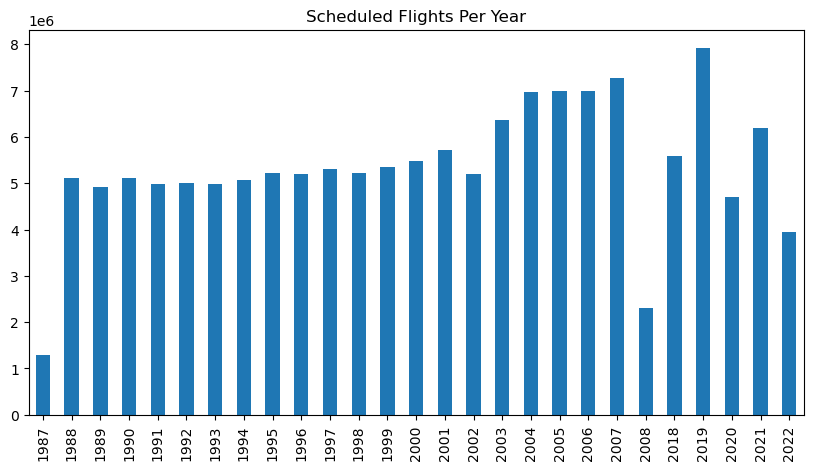

In [21]:
data_df['Year'].value_counts().sort_index().plot(kind="bar", figsize=(10, 5), title="Scheduled Flights Per Year", stacked=True)
plt.savefig('figures/FlightCountPerYear.png')

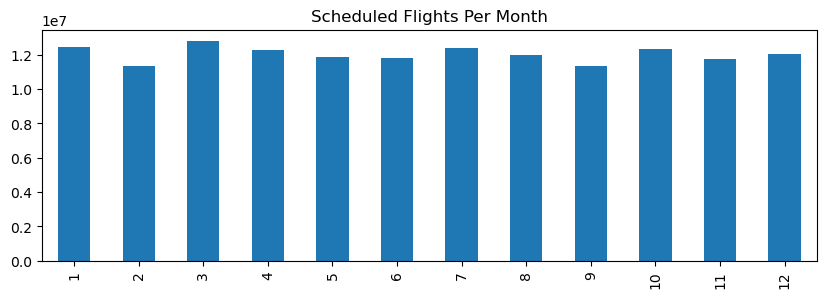

In [22]:
data_df['Month'].value_counts().sort_index().plot(kind="bar", figsize=(10, 3), title="Scheduled Flights Per Month")
plt.savefig('figures/FlightCountPerMonth.png')

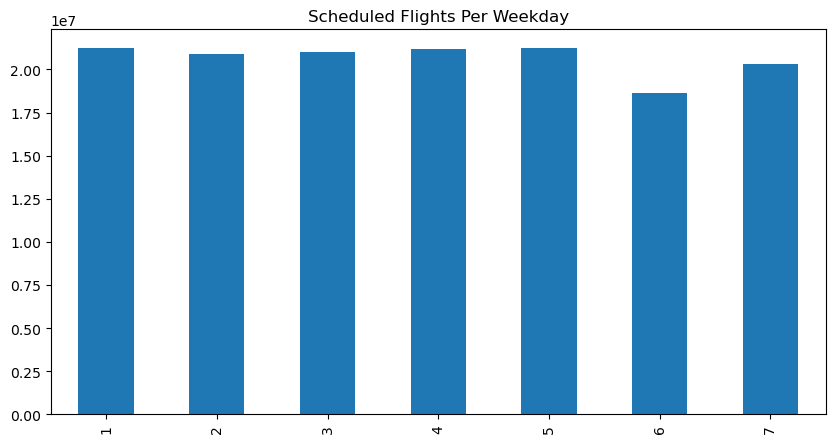

In [23]:
data_df['DayOfWeek'].value_counts().sort_index().plot(kind="bar", figsize=(10, 5), title="Scheduled Flights Per Weekday")
plt.savefig('figures/FlightCountPerWeekday.png')

### Corona impact on delays

In this section we aim to improve our understanding of how the policies to reduce the spread of the corona virus in its earlier stages affected the aviation industry with respect to flights and delays.


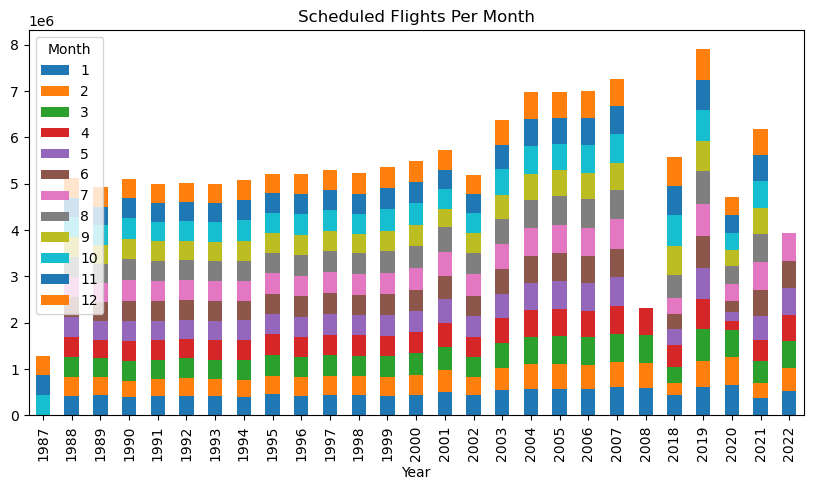

In [24]:
data_df.groupby(['Year', 'Month']).size().unstack().plot(kind='bar', figsize=(10, 5), title='Scheduled Flights Per Month', stacked=True)
plt.savefig('figures/FlightCountPerMonthPerYear.png')

#### Average monthly flights for pre-pandemic, during the pandemic, and post-pandemic

We define 2020 as the pandemic year. This is the year that traveling restrictions went into affect...

In [25]:
pre_pandemic: pd.DataFrame = data_df[data_df['Year'] < 2020]
pandemic: pd.DataFrame = data_df[data_df['Year'] == 2020]
post_pandemic: pd.DataFrame = data_df[data_df['Year'] > 2020]

In [26]:
pre_pandemic: pd.DataFrame = data_df[data_df['Year'] == 2019]
pandemic: pd.DataFrame = data_df[data_df['Year'] == 2020]
post_pandemic: pd.DataFrame = data_df[data_df['Year'] == 2021]

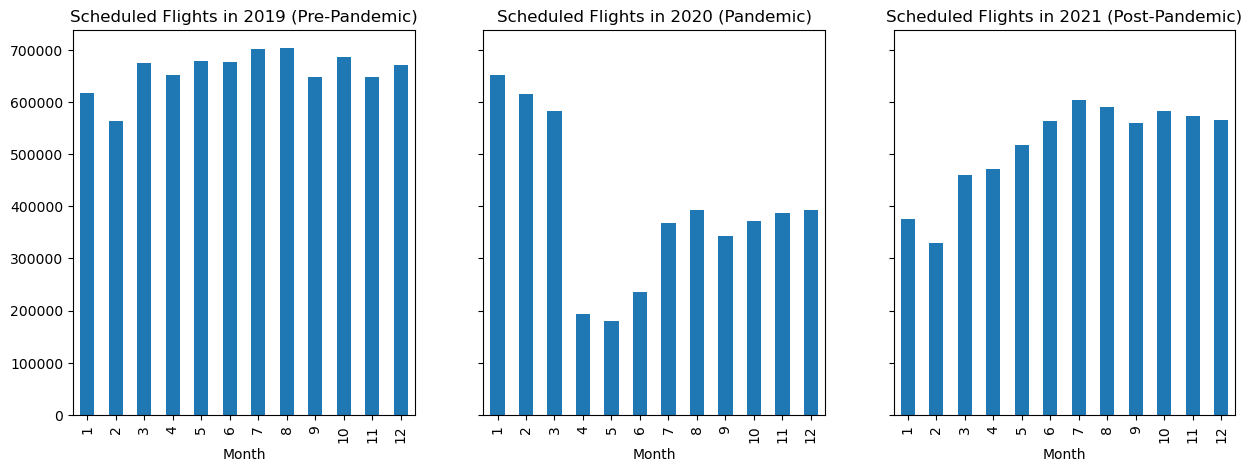

In [27]:
_, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
pre_pandemic.groupby(['Month'])['Airline'].count().plot(kind='bar', ax=axes[0], title='Scheduled Flights in 2019 (Pre-Pandemic)')
pandemic.groupby(['Month'])['Airline'].count().plot(kind='bar', ax=axes[1], title='Scheduled Flights in 2020 (Pandemic)')
post_pandemic.groupby(['Month'])['Airline'].count().plot(kind='bar', ax=axes[2], title='Scheduled Flights in 2021 (Post-Pandemic)')
plt.savefig('figures/FlightCountPerMonthPrePandemic.png')

### Corrlation matrix

<Axes: >

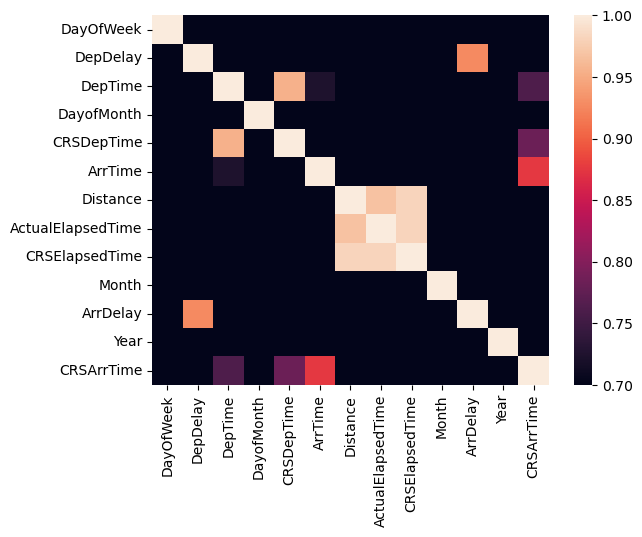

In [28]:
sns.heatmap(data_df.drop(columns=['Cancelled', 'Diverted']).corr(numeric_only=True).abs(), vmin=0.7)